# Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10
# Библиотеки: [Python, Tensorflow]

## Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

import random

## Load, view and prep

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

def view_info(arr):
    print(f'size: {arr.shape}, max: {arr.max()}, type: {arr.dtype}')

view_info(train_x)
view_info(test_x)
view_info(train_y)
view_info(test_y)

size: (50000, 32, 32, 3), max: 255, type: uint8
size: (10000, 32, 32, 3), max: 255, type: uint8
size: (50000, 1), max: 9, type: uint8
size: (10000, 1), max: 9, type: uint8


In [3]:
train_x = train_x.astype(np.float32) / 255
test_x = test_x.astype(np.float32) / 255

train_y = train_y.reshape(-1).astype(np.int32)
test_y = test_y.reshape(-1).astype(np.int32)

view_info(train_x)
view_info(test_x)
view_info(train_y)
view_info(test_y)

size: (50000, 32, 32, 3), max: 1.0, type: float32
size: (10000, 32, 32, 3), max: 1.0, type: float32
size: (50000,), max: 9, type: int32
size: (10000,), max: 9, type: int32


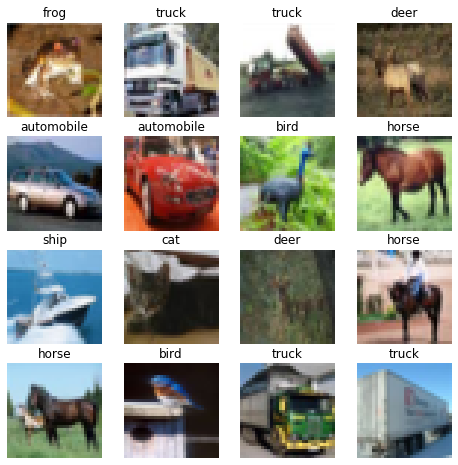

In [4]:
label_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, 1+i)
    plt.imshow(train_x[i])
    plt.title(label_names[train_y[i]])
    plt.axis('off')

## Pipline

In [5]:
NUM_EPOCHS = 5
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Model

In [6]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')
        self.conv2 = layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same')
        
        self.dense1 = layers.Dense(units=256, activation='relu')
        self.dense2 = layers.Dense(units=10, activation=None)
        
        self.max_pool = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.flatten = layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        
        out = self.conv2(out)
        out = self.max_pool(out)
        
        out = self.flatten(out)
        
        out = self.dense1(out)
        out = self.dense2(out)
        
        return out

## Loss & Accuracy

In [7]:
def loss(logits, labels):
    result = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    result = tf.reduce_mean(result)
    return result

def accuracy(logits, labels):
    preds = tf.argmax(logits, axis=1, output_type=tf.int32)
    preds = tf.equal(preds, labels)
    preds = tf.cast(preds, dtype=tf.float32)
    preds = tf.reduce_mean(preds)
    return preds

## Training

In [8]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Nadam(LEARNING_RATE)
writer = tf.summary.create_file_writer('logs/nadam')

In [9]:
%%time
test_num = 64

train_loss = []
train_acc = []

test_loss = []
test_acc = []

model = Model()
for i, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        train_logits = model(images)
        train_loss_value = loss(logits=train_logits, labels=labels)
        
    # Backward
    grads = tape.gradient(train_loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Calc and display loss/accuracy
    if i % 200 == 0:
        test_logits = model(test_x[:test_num])
        
        test_loss_value = loss(logits=test_logits, labels=test_y[:test_num])
        
        test_accuracy_value = accuracy(logits=test_logits, labels=test_y[:test_num])
        train_accuracy_value = accuracy(logits=train_logits, labels=labels)
        
        test_loss.append(test_loss_value.numpy())
        test_acc.append(test_accuracy_value.numpy())
        
        train_loss.append(train_loss_value.numpy())
        train_acc.append(train_accuracy_value.numpy())
        
        print(f"{i}\ttrain accuracy: {round(train_acc[-1]*100, 2)}%\ttest accuracy: {round(test_acc[-1]*100, 2)}%")

0	train accuracy: 6.25%	test accuracy: 14.06%
200	train accuracy: 51.56%	test accuracy: 53.12%
400	train accuracy: 57.81%	test accuracy: 57.81%
600	train accuracy: 59.38%	test accuracy: 64.06%
800	train accuracy: 68.75%	test accuracy: 67.19%
1000	train accuracy: 57.81%	test accuracy: 67.19%
1200	train accuracy: 70.31%	test accuracy: 70.31%
1400	train accuracy: 67.19%	test accuracy: 75.0%
1600	train accuracy: 78.12%	test accuracy: 76.56%
1800	train accuracy: 76.56%	test accuracy: 75.0%
2000	train accuracy: 62.5%	test accuracy: 76.56%
2200	train accuracy: 73.44%	test accuracy: 75.0%
2400	train accuracy: 67.19%	test accuracy: 70.31%
2600	train accuracy: 82.81%	test accuracy: 78.12%
2800	train accuracy: 76.56%	test accuracy: 84.38%
3000	train accuracy: 89.06%	test accuracy: 73.44%
3200	train accuracy: 92.19%	test accuracy: 73.44%
3400	train accuracy: 75.0%	test accuracy: 76.56%
3600	train accuracy: 78.12%	test accuracy: 79.69%
3800	train accuracy: 79.69%	test accuracy: 79.69%
Wall time: 1m

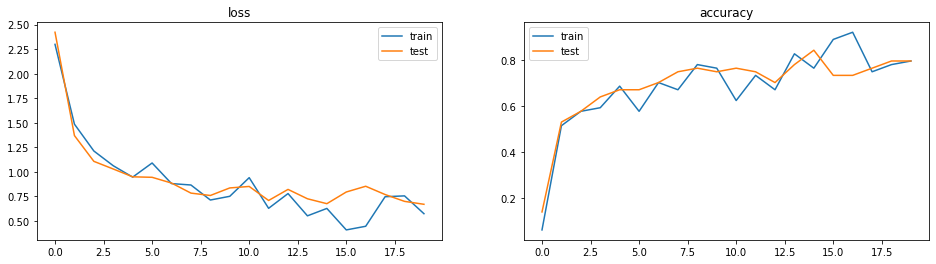

In [10]:
plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
plt.title('loss')
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy')
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()

plt.show()

## Testing

In [11]:
test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print(f"Test accuracy: {round(accuracy_value * 100, 2)}%")

Test accuracy: 68.91%


## View pred

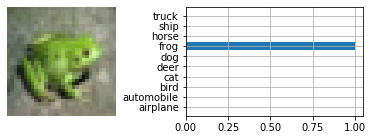

true: frog
pred: frog


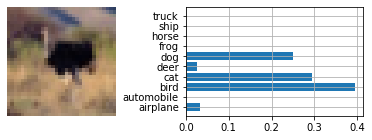

true: bird
pred: bird


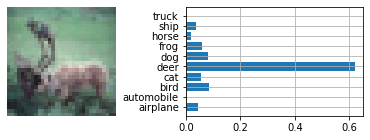

true: deer
pred: deer


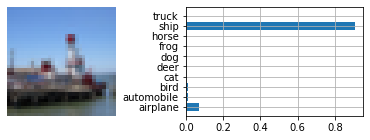

true: ship
pred: ship


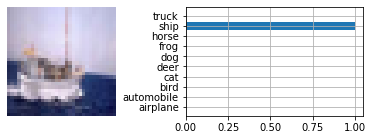

true: ship
pred: ship


In [12]:
for i in range(5):
    idx = random.randint(0, test_x.shape[0])

    pred = model(test_x[idx][None])[0]
    pred = tf.nn.softmax(pred)

    plt.figure(figsize=(7, 2))

    # # img
    plt.subplot(1, 2, 1)
    plt.imshow(test_x[idx])
    plt.axis('off')

    # # accuracy
    plt.subplot(1, 2, 2)
    plt.barh(label_names, pred)
    plt.grid(True)

    plt.show()

    print('true:', label_names[test_y[idx]]) 
    print('pred:', label_names[np.argmax(pred)])